In [96]:
import pandas as pd
import dask as dask
from dask import dataframe as dd
import numpy as np
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask.array as da
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import seaborn as sns
import ipywidgets as widgets
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [97]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='7000MiB', #1 GiB = 1,024 MiB
    processes=1)

cluster.scale(10)
#cluster.adapt(minimum=3, maximum=20)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [98]:
client = Client(cluster)

In [101]:
client

Client Scheduler: tcp://169.226.65.50:45809 Dashboard: http://169.226.65.50:38503/status,Cluster Workers: 10 Cores: 10 Memory: 73.40 GB


In [146]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_lastmono.sqlite")]
tables = ['aggregates', 'crystals']


In [147]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 7.98 s, sys: 616 ms, total: 8.6 s
Wall time: 1min 22s


## Memory info and df stats

In [8]:
df_repart.compute().memory_usage(deep=True).sum()/1E9
#in GB

NameError: name 'df_repart' is not defined

In [ ]:
df[1].info(memory_usage='deep')

In [ ]:
#see partitions
print(df[0].npartitions)
print(df[1].npartitions)

In [ ]:
len(df[0]), len(df[1]) 

In [49]:
df_agg = client.persist(df[0]) 

In [50]:
df_mono = client.persist(df[1]) 

In [15]:
agg_stats = df[0]['agg_phi'].describe().round(2).compute()
agg_stats

count    8232439.00
mean           3.98
std            6.74
min            0.01
25%            0.31
50%            2.76
75%           30.08
max           78.33
Name: agg_phi, dtype: float64

In [16]:
r_stats = df[0]['agg_r'].describe().round(2).compute()
r_stats

count    8232439.00
mean        2454.65
std         5282.27
min            0.46
25%          122.19
50%         1349.11
75%        43820.08
max        67900.97
Name: agg_r, dtype: float64

In [17]:
r_stats = df[1]['r'].describe().round(2).compute()
r_stats

count    8232439.00
mean         214.12
std          304.44
min            1.00
25%           17.50
50%          150.00
75%         1000.00
max         1000.00
Name: r, dtype: float64

In [18]:
phi_stats = df[1]['phi'].describe().round(2).compute()
phi_stats

count    8232439.00
mean          13.01
std           25.22
min            0.01
25%            0.18
50%            5.46
75%          100.00
max          100.00
Name: phi, dtype: float64

In [195]:
#len(df_crys[df_crys.r == 50])
# frequency count of mono r
count = df[1].r.value_counts() 
# Multi-column frequency count 
count = df_repart.groupby(['agg_phi']).count().compute()
print(count)

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py", line 652, in log_errors
    yield
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3134, in replicate
    assert count > 0
AssertionError
distributed.core - ERROR - 
Traceback (most recent call last):
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/core.py", line 412, in handle_comm
    result = await result
  File "/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/scheduler.py", line 3380, in retire_workers
    lock=False,
  File "/network/rit/lab/sulialab/sha

KeyboardInterrupt: 

## Concat, Repartition, and Clean Up DFs

In [148]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 10.4 ms, sys: 754 µs, total: 11.2 ms
Wall time: 14.1 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [149]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))
df_concat.agg_phi = 1/df_concat.agg_phi
agg_stats = df_concat['agg_phi'].describe().round(2).compute()
agg_stats

count    8059953.00
mean           1.64
std            2.59
min            0.01
25%            0.32
50%            2.01
75%            5.66
max          131.21
Name: agg_phi, dtype: float64

In [141]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
len(df_concat) #86% of dataset

7353353

In [142]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

58

In [108]:
res.value_counts()

(1.6600000000000001, 26.516]    16419
(2971.799, 3749.811]            16418
(26.516, 45.503]                16418
(45.503, 68.231]                16418
(68.231, 95.026]                16418
(95.026, 123.736]               16418
(123.736, 157.962]              16418
(157.962, 197.087]              16418
(197.087, 245.454]              16418
(245.454, 309.674]              16418
(3749.811, 4999.995]            16418
(400.452, 541.364]              16418
(541.364, 756.187]              16418
(756.187, 997.084]              16418
(997.084, 1263.33]              16418
(1263.33, 1586.325]             16418
(1586.325, 1953.495]            16418
(1953.495, 2401.196]            16418
(2401.196, 2971.799]            16418
(309.674, 400.452]              16418
Name: agg_r, dtype: int64

In [143]:
agg_stats = df_repart['agg_phi'].describe().round(2).compute()
agg_stats

count    7353353.00
mean           2.19
std            3.38
min            0.01
25%            0.33
50%            2.95
75%            7.01
max          147.51
Name: agg_phi, dtype: float64

In [33]:
#df_concat._meta.dtypes
#df_concat.divisions
print(df_concat.npartitions)
print(df_concat.memory_usage(deep=True).sum().compute() / 1024**2)  #5.1 GB

200
5103.192663192749


## Test agg agg queries for collection 

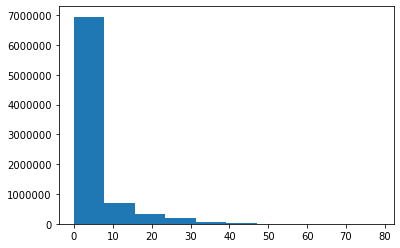

In [193]:
plt.hist(df_repart.agg_phi.compute(), bins =10)
plt.show()

In [55]:
#FLAT
file = open('instance_files/instance_db_aggagg_flat_returnclus1', 'rb')
bflat = pickle.load(file)

#a=z b=y c=x

#dunnavan: a>= b >= c
#in our case z >= y >= x

nclusters = 300
rxs_flat = np.zeros((20,20,nclusters))
rys_flat = np.zeros((20,20,nclusters))
rzs_flat = np.zeros((20,20,nclusters))
phi2Ds_flat = np.zeros((20,20,nclusters))
cplxs_flat = np.zeros((20,20,nclusters))
dds_flat = np.zeros((20,20,nclusters))
cluster1_ncrystals_flat = np.zeros((20,20,nclusters))
cluster2_ncrystals_flat = np.zeros((20,20,nclusters))

counter=0
for phi in range(20):
    for r in range(20):
        rxs_flat[phi, r, :] = np.array(bflat[counter][0])[:,0]
        rys_flat[phi, r, :] = np.array(bflat[counter][0])[:,1]
        rzs_flat[phi, r, :] = np.array(bflat[counter][0])[:,2]
        phi2Ds_flat[phi, r, :] = bflat[counter][1]
        cplxs_flat[phi, r, :] = bflat[counter][2]
        dds_flat[phi, r, :] = bflat[counter][3]
        cluster1_ncrystals_flat[phi, r, :] = bflat[counter][4]
        cluster2_ncrystals_flat[phi, r, :]= bflat[counter][5]
        counter+=1
phiba_flat = rys_flat/rzs_flat
phica_flat = rxs_flat/rzs_flat
np.shape(phica_flat)

(20, 20, 300)

In [66]:
#RAND
file = open('instance_files/instance_db_aggagg_rand_returnclus1', 'rb')
brand = pickle.load(file)

#a=z b=y c=x

#dunnavan: a>= b >= c
#in our case z >= y >= x

nclusters = 300
rxs_rand = np.zeros((20,20,nclusters))
rys_rand = np.zeros((20,20,nclusters))
rzs_rand = np.zeros((20,20,nclusters))
phi2Ds_rand = np.zeros((20,20,nclusters))
cplxs_rand = np.zeros((20,20,nclusters))
dds_rand = np.zeros((20,20,nclusters))
cluster1_ncrystals_rand = np.zeros((20,20,nclusters))
cluster2_ncrystals_rand = np.zeros((20,20,nclusters))

counter=0
for phi in range(20):
    for r in range(20):
        rxs_rand[phi, r, :] = np.array(brand[counter][0])[:,0]
        rys_rand[phi, r, :] = np.array(brand[counter][0])[:,1]
        rzs_rand[phi, r, :] = np.array(brand[counter][0])[:,2]
        phi2Ds_rand[phi, r, :] = brand[counter][1]
        cplxs_rand[phi, r, :] = brand[counter][2]
        dds_rand[phi, r, :] = brand[counter][3]
        cluster1_ncrystals_rand[phi, r, :] = brand[counter][4]
        cluster2_ncrystals_rand[phi, r, :]= brand[counter][5]
        counter+=1
phiba_rand = rys_rand/rzs_rand
phica_rand = rxs_rand/rzs_rand
np.shape(phica_rand)

(20, 20, 300)

In [113]:
#FLAT Ncrystals
file = open('instance_files/pulled_clusters_flat1', 'rb')
bflat = pickle.load(file)

nclusters = 301
cluster1_ncrystals_flat = np.zeros((20,20,nclusters))

counter=0
for phi in range(20):
    for r in range(20):
        for n in range(301):
            cluster1_ncrystals_flat[phi, r, :] = [n.ncrystals for n in bflat[phi, r, :]]

        counter+=1


In [76]:
#FLAT Ncrystals
file = open('instance_files/pulled_clusters_rand', 'rb')
brand = pickle.load(file)

nclusters = 301
cluster1_ncrystals_rand = np.zeros((20,20,nclusters))

counter=0
for phi in range(20):
    for r in range(20):
        for n in range(301):
            cluster1_ncrystals_rand[phi, r, :] = [n.ncrystals for n in brand[phi, r, :]]

        counter+=1


In [67]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df.r.mean().compute())
    return avg_ncrystals


In [68]:
def avg_ncrystals_afteragg(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        avg_ncrystals.append(np.mean(cluster1_ncrystals_flat[i,r,:])+np.mean(cluster2_ncrystals_flat[i,r,:]))
    return avg_ncrystals

In [69]:
def avg_cplx(i, r_bins):
    avg_cplx = []
    for r in range(len(r_bins)-1):
        avg_cplx.append(np.mean(cplxs_flat[i,r,:]))
    return avg_cplx


In [59]:
#FLAT
res, phi_bins_flat = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
%store phi_bins_flat
#print(phi_bins)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins_flat)-1,len(phi_bins_flat)-1))
avg_cplxs=np.empty((len(phi_bins_flat)-1,len(phi_bins_flat)-1))
all_r_bins_flat = np.empty((len(phi_bins_flat),len(phi_bins_flat)))


for i in range(len(phi_bins_flat)-1):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins_flat[i],phi_bins_flat[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df_repart[(df_repart.agg_phi > phi_bins_flat[i]) & (df_repart.agg_phi < phi_bins_flat[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins_flat = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
    
    all_r_bins_flat[i,:]=r_bins_flat
    #now use those r bins from the output of queried r and phi to find # of monomers per bin
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins_flat)
    avg_ncrystals[i,:] = avg_ncrystals_afteragg(i, r_bins_flat)
    avg_cplxs[i,:] = avg_cplx(i, r_bins_flat)
    
%store all_r_bins_flat    

Stored 'phi_bins_flat' (ndarray)
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
Stored 'all_r_bins_flat' (ndarray)


In [72]:
#RAND
res, phi_bins_rand = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
%store phi_bins_rand
#print(phi_bins)
phi_bin_labs = []
avg_ncrystals=np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))
avg_cplxs=np.empty((len(phi_bins_rand)-1,len(phi_bins_rand)-1))
all_r_bins_rand = np.empty((len(phi_bins_rand),len(phi_bins_rand)))


for i in range(len(phi_bins_rand)-1):
    print('i = ', i)
    phi_bin_labs.append('[%.3f-%.3f]' %(phi_bins_rand[i],phi_bins_rand[i+1]))
    #return a df that only queries within an aspect ratio bin
    df_phi = df_repart[(df_repart.agg_phi > phi_bins_rand[i]) & (df_repart.agg_phi < phi_bins_rand[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins_rand = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
    
    all_r_bins_rand[i,:] = r_bins_rand
    #now use those r bins from the output of queried r and phi to find # of monomers per bin
    avg_ncrystals[i,:] = query_ncrystals(df_phi, r_bins_rand)
    avg_ncrystals[i,:] = avg_ncrystals_afteragg(i, r_bins_rand)
    avg_cplxs[i,:] = avg_cplx(i, r_bins_rand)
    
%store all_r_bins_rand    

Stored 'phi_bins_rand' (ndarray)
i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16
i =  17
i =  18
i =  19
Stored 'all_r_bins_rand' (ndarray)


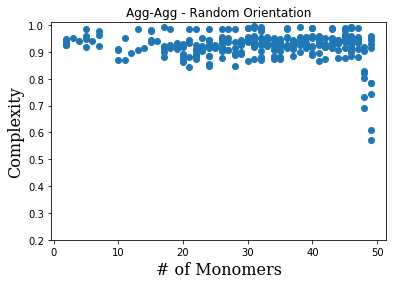

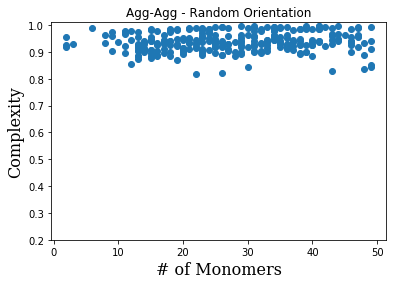

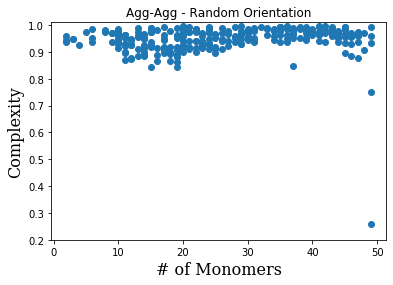

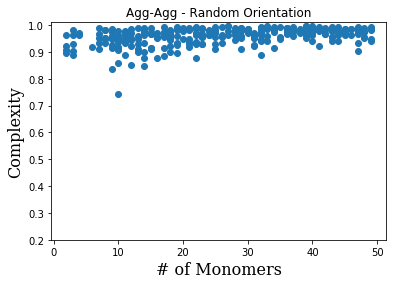

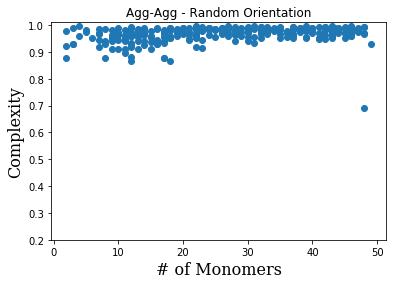

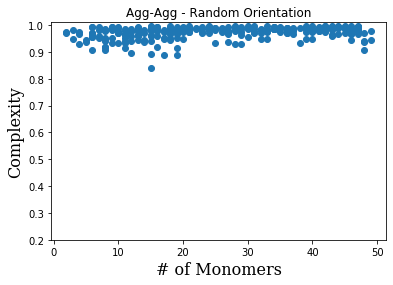

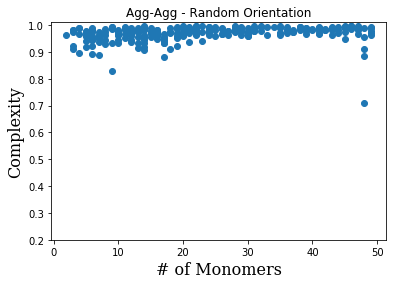

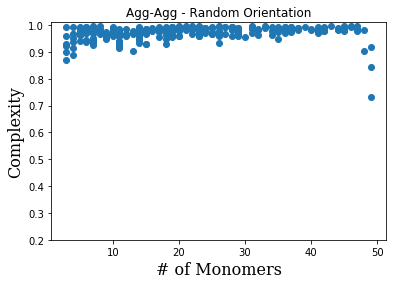

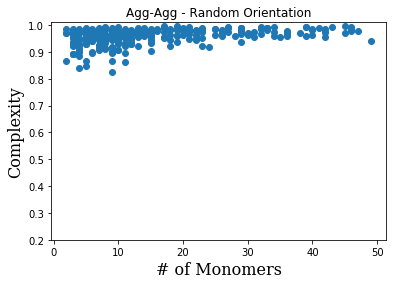

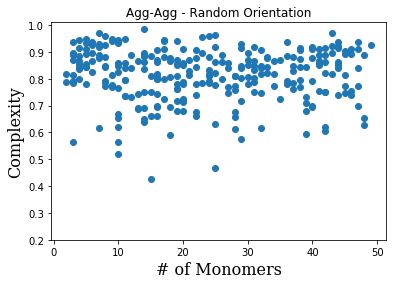

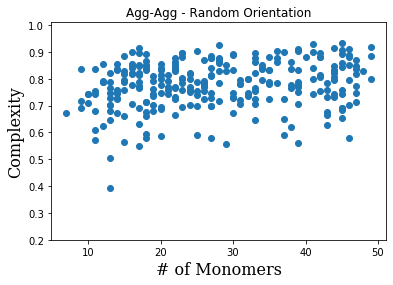

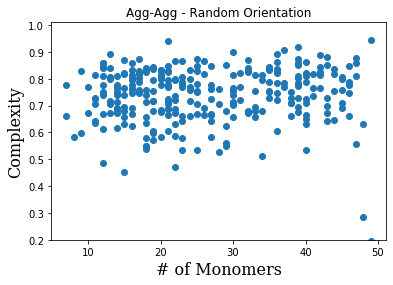

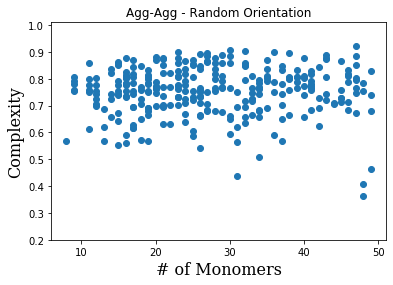

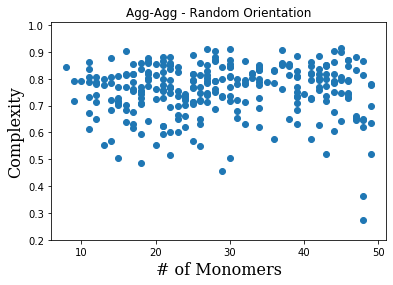

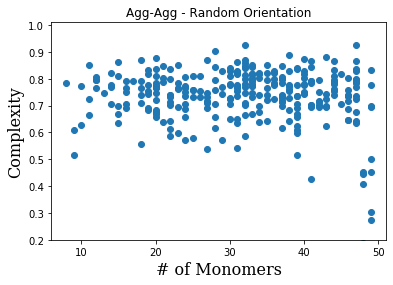

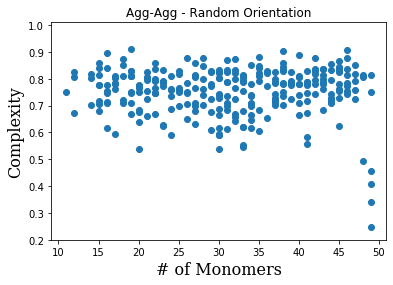

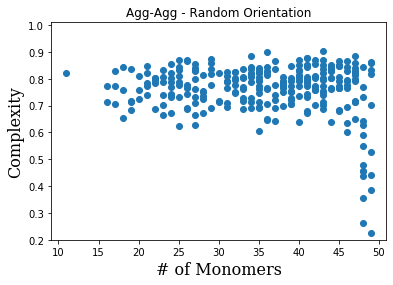

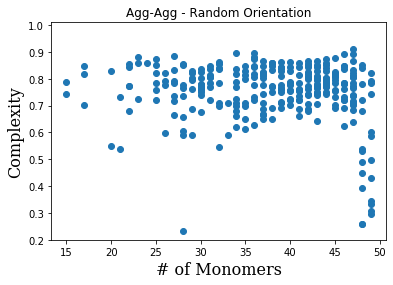

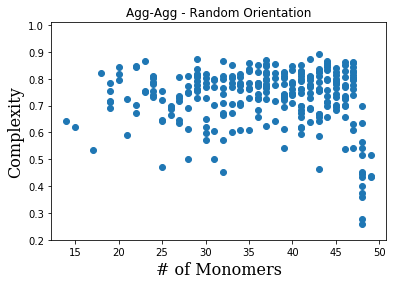

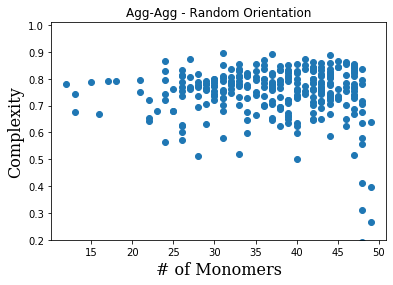

In [55]:
cm = plt.cm.get_cmap('viridis')
for phi in range(20):
    fig, ax = plt.subplots()

    #for r in range(20):
    plt.scatter(cluster1_ncrystals_flat[phi,19,:], cplxs_flat[phi,19,:])
    plt.ylim(0.2, 1.01)
    plt.xlabel('# of Monomers', fontsize=16, family='serif');
    plt.ylabel('Complexity', fontsize=16, family='serif');
    plt.title('Agg-Agg - Random Orientation')
#cbar = plt.colorbar()
cbar.ax.set_ylabel('Complexity', fontsize=16, family='serif');

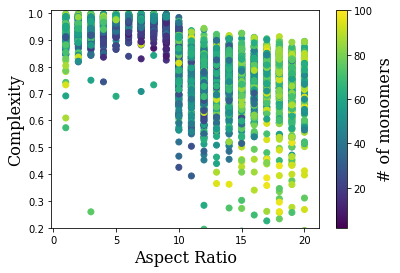

In [45]:
cm = plt.cm.get_cmap('viridis')
r=19
for n in range(300):
    plt.scatter(np.linspace(1,20,20), cplxs_flat[:,r,n], \
                c=(cluster1_ncrystals_flat[:,r,n]+cluster2_ncrystals_flat[:,r,n]), \
                cmap=cm, vmin=2, vmax=100)
plt.ylim(0.2, 1.01)
plt.xlabel('Aspect Ratio', fontsize=16, family='serif');
plt.ylabel('Complexity', fontsize=16, family='serif');
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of monomers', fontsize=16, family='serif');

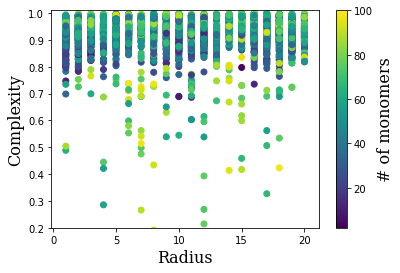

In [46]:
cm = plt.cm.get_cmap('viridis')
phi=1
for n in range(300):
    plt.scatter(np.linspace(1,20,20), cplxs_flat[phi,:,n], \
            c=(cluster1_ncrystals_flat[phi,:,n]+cluster2_ncrystals_flat[phi,:,n]), \
            cmap=cm, vmin=2, vmax=100)
plt.ylim(0.2, 1.01)
plt.xlabel('Radius', fontsize=16, family='serif');
plt.ylabel('Complexity', fontsize=16, family='serif');
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of monomers', fontsize=16, family='serif');

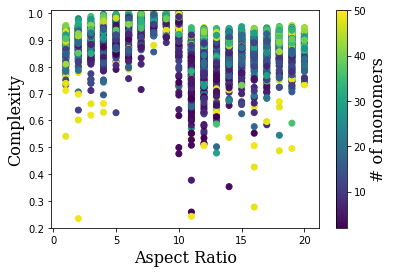

In [160]:
cm = plt.cm.get_cmap('viridis')
for n in range(300):
    plt.scatter(np.linspace(1,20,20), cplxs_rand[:,19,n], c=cluster1_ncrystals_rand[:,19,n], cmap=cm, vmin=2, vmax=50)
plt.ylim(0.2, 1.01)
plt.xlabel('Aspect Ratio', fontsize=16, family='serif');
plt.ylabel('Complexity', fontsize=16, family='serif');
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of monomers', fontsize=16, family='serif');

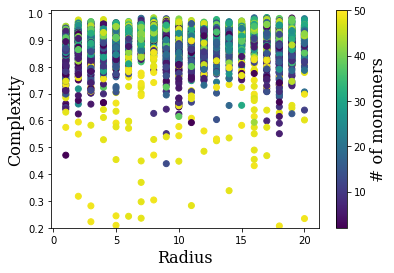

In [157]:
cm = plt.cm.get_cmap('viridis')
for n in range(300):
    plt.scatter(np.linspace(1,20,20), cplxs_rand[1,:,n], c=cluster1_ncrystals_rand[1,:,n], cmap=cm, vmin=2, vmax=50)
plt.ylim(0.2, 1.01)
plt.xlabel('Radius', fontsize=16, family='serif');
plt.ylabel('Complexity', fontsize=16, family='serif');
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of monomers', fontsize=16, family='serif');
#plt.savefig('')

i=  0
i=  1
i=  2
i=  3
i=  4
i=  5
i=  6
i=  7
i=  8
i=  9
i=  10
i=  11
i=  12
i=  13
i=  14
i=  15
i=  16
i=  17
i=  18
i=  19


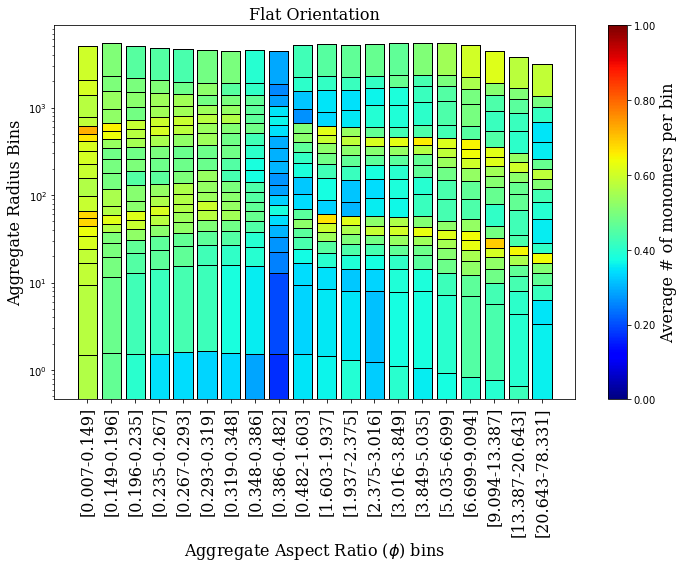

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.cm.jet
# vmin=np.amin(avg_cplxs)
# vmax=np.amax(avg_cplxs)
# print(vmin, vmax) 
#1.3914486210085406 907.974759288473   flat r max min
#1.2451487710219922 640.6597671410091  rand r

#flat
#mono_r = vmin=np.amin(avg_ncrystals), vmax=np.amax(avg_ncrystals)
#norm = matplotlib.colors.LogNorm(vmin=1.2, vmax=900)
norm = matplotlib.colors.Normalize(vmin=4, vmax=100)

#norm = matplotlib.colors.LogNorm(vmin=0.5, vmax=1.0)

for i in range(len(phi_bins)-1): 
    print('i= ', i)
    for r in range(len(r_bins)-2):
        if r != 0:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], bottom= all_r_bins[i,r-1],  color=cmap(norm(np.mean(cluster1_ncrystals_flat[i,r,:]+cluster2_ncrystals_flat[i,r,:]))),edgecolor='k')

        else:
            plt.bar([i]*len(r_bins), all_r_bins[i,r], color=cmap(norm(np.mean(cluster1_ncrystals_flat[i,r,:]+cluster2_ncrystals_flat[i,r,:]))), edgecolor='k')
        
#     for x,y in zip([i]*len(r_bins), r_bins):

#         label = "{:.2f}".format(y)

#         plt.annotate(label, # this is the text
#                      (x,y), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,1), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center

    
plt.yscale('log')
plt.xticks(np.arange(len(phi_bin_labs)), phi_bin_labs, rotation=90, ha="center",fontsize=16,family='serif')
plt.ylabel("Aggregate Radius Bins",fontsize=16,family='serif')
plt.xlabel("Aggregate Aspect Ratio ($\phi$) bins",fontsize=16,family='serif')  
cb = plt.cm.ScalarMappable(cmap=cmap)
cbar = plt.colorbar(cb,format='%.2f')
#cbar.ax.set_ylabel('Average # of monomers per bin', fontsize=16, family='serif')
cbar.ax.set_ylabel('Average # of monomers per bin', fontsize=16, family='serif')
#plt.title('Quasi-Horizontal Orientation',fontsize=16, family='serif')
plt.title('Flat Orientation',fontsize=16, family='serif')
plt.tight_layout()
#plt.savefig('bins_rand_meanmono_r_5000rad_logy.pdf')

#sm.set_label('Average # of monomers in the aggregates')
#textstr = '$n$ values per $phi$ :', str(res.value_counts()[0])
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
#        vertical alignment='top', bbox=dict(boxstyle='round'))
#17716 values per phi, per r

In [130]:
#switch a and c
col_list = list(df_repart)
print(col_list)
col_list[3], col_list[5] = col_list[5], col_list[3]
# assign back, the order will now be swapped
df_repart.columns = col_list

['ncrystals', 'agg_phi', 'agg_r', 'a', 'b', 'c', 'cplx', 'phi2D', 'phi', 'r', 'points', 'agg_id']


In [132]:
# df_repart['c'] = pd.DataFrame([df_repart['a'], df_repart.c]).min(axis=1)
# df_repart['a'] = pd.DataFrame([df_repart['a'], df_repart.c]).max(axis=1)
df_repart['agg_phi'] = df_repart.c/df_repart.a
df_repart['shape'] = df_repart.apply(lambda row: 'prolate' if (row.c - row.b) <= (row.a - row.b) else 'oblate', axis=1)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/core.py:4096: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [115]:
res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), 20, retbins=True)
shape = np.empty((len(phi_bins), len(r_bins)), dtype=str)
print(phi_bins)
for i in range(len(phi_bins)-1):
    print('i = ', phi_bins[i], phi_bins[i+1])
    #return a df that only queries within an aspect ratio bin
    df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1])]
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r.compute(), 20, retbins=True)
    for r in range(len(r_bins)-1):
        print('r =', r_bins[r], r_bins[r+1])
        df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])].compute() 

        oblates = df_r['shape'][df_r['shape'] == 'oblate'].count()
        prolates = df_r['shape'][df_r['shape'] == 'prolate'].count()
       
        print(oblates, prolates)
        shape[i,r] = 'oblates' if oblates > prolates else 'prolates'
 

[0.00762154 0.1639163  0.18958468 0.20931429 0.22702575 0.24396513
 0.26078188 0.27789235 0.2954544  0.3137224  0.33357768 0.35509309
 0.37899554 0.40569367 0.43559609 0.46890237 0.50520364 0.54571151
 0.59349843 0.65792836 0.97114727]
i =  0.00762154416061802 0.16391629839854172
r = 1.100183520972879 9.320353474275915
0 16418
r = 9.320353474275915 16.81884995781623
0 16418
r = 16.81884995781623 24.508714370755513
0 16418
r = 24.508714370755513 34.478156739569165
0 16418
r = 34.478156739569165 44.99214992797235
0 16418
r = 44.99214992797235 56.29822249222366
0 16418
r = 56.29822249222366 70.24238733165042
0 16418
r = 70.24238733165042 92.68543893553506
0 16418
r = 92.68543893553506 157.0943551095397
0 16418
r = 157.0943551095397 229.7944662363828
0 16418
r = 229.7944662363828 329.8788696412976
0 16418
r = 329.8788696412976 432.502246960299
0 16418
r = 432.502246960299 532.0403304760335
0 16418
r = 532.0403304760335 653.1610522001379
0 16418
r = 653.1610522001379 810.3950690285046
0 164

KeyboardInterrupt: 

In [137]:
oblates = df_repart['shape'][df_repart['shape']  == 'oblate'].count().compute()
prolates = df_repart['shape'][df_repart['shape']  == 'prolate'].count().compute()
print(oblates, prolates)

0 7353353
